In [1]:
import torch
from torch import Tensor
from mmrotate.core import build_assigner
import matplotlib.pyplot as plt
from mmrotate.core.bbox.assigners.gaussian_assigner import normalized_gaussian_distance_scores, gaussian_distance_scores, add_regress_range_to_mask

In [5]:
def _positions(width: int, height: int, stride: int) -> Tensor:
    offset, step = torch.floor(torch.tensor(stride) / 2), stride
    positions = torch.stack(torch.meshgrid(
        torch.arange(offset, offset + width * step, step),  # type: ignore
        torch.arange(offset, offset + height * step, step),  # type: ignore
        indexing='ij')).flatten(1).transpose(0, 1)
    return positions

Assigner = build_assigner(dict(type='GaussianAssigner'))
Bboxes = torch.tensor([[512, 512, 128, 256, 2.4], [256, 128, 128, 256, 0.7]])
Points = _positions(128, 128, 8)
Strides = torch.full_like(Points[:, 0], 8)
Regranges = torch.full_like(Points, -1)
Regranges[:, 1] = int(1e9)

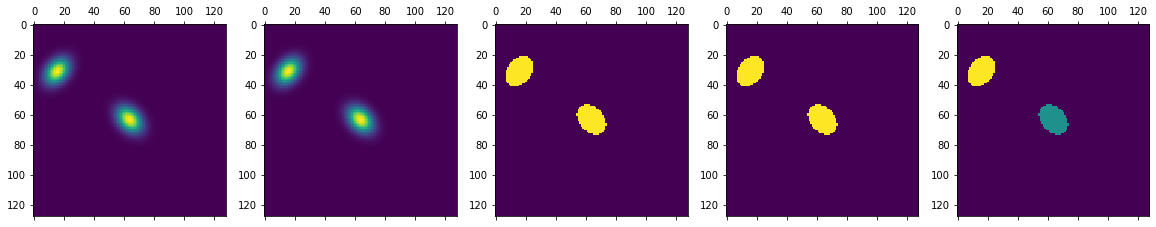

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

Nscores = normalized_gaussian_distance_scores(Bboxes, Points, 12.0)
axs[0].matshow(Nscores.sum(0).view((128, 128)).numpy())

Nscores2, Rscores = gaussian_distance_scores(Bboxes, Points, 12.0, 1e-6)
assert (Nscores == Nscores2).all()
axs[1].matshow(Rscores.sum(0).view((128, 128)).numpy())

Inside_mask = Nscores >= 0.23
axs[2].matshow(Inside_mask.sum(0).view((128, 128)).numpy())

add_regress_range_to_mask(Bboxes, Points, Inside_mask, Strides, Regranges)
axs[3].matshow(Inside_mask.sum(0).view((128, 128)).numpy())

Gt_inds = Assigner.assign(Bboxes, Points, Strides, Regranges).info['gt_inds']
axs[4].matshow(Gt_inds.view((128, 128)).numpy())